In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import h5py

from cca import ComplexityComponentsAnalysis
import cca.synth_data

In [384]:
def gen_noise_cov(N, d, variance):
    noise_spectrum = variance*np.exp(-np.arange(N)/(d/2))
    noise_V = scipy.stats.ortho_group.rvs(N)
    noise_cov = np.dot(noise_V, np.dot(np.diag(noise_spectrum), noise_V.T))
    return noise_cov

def cca_pca(N, T, cross_cov_mats, min_dim=1, max_dim=None, num_reps=1):
    opt = ComplexityComponentsAnalysis(T=T, init="random_ortho", device=None)
    opt.cross_covs = cross_cov_mats
    
    w, V = scipy.linalg.eigh(cross_cov_mats[0])
    w, V = w[::-1], V[:, ::-1]
    #pve = np.cumsum(w) / np.sum(w)
    
    if max_dim is None:
        max_dim = N
        
    dim_vals = np.arange(min_dim, max_dim+1)
    cca_pi_vals = np.zeros((len(dim_vals), num_reps))
    pca_pi_vals = np.zeros(len(dim_vals))
    V_set = []
    
    for dim_idx in range(len(dim_vals)):
        opt_dim = dim_vals[dim_idx]
        V_set_for_dim = []
        for rep_idx in range(num_reps):
            opt.fit_projection(d=opt_dim)
            V_set_for_dim.append(opt.coef_)
            cca_pi = opt.score()
            cca_pi_vals[dim_idx, rep_idx] = cca_pi
        V_set.append(V_set_for_dim)
        opt.coef_ = V[:, :opt_dim]
        pca_pi = opt.score()
        pca_pi_vals[dim_idx] = pca_pi
        
        print(opt_dim, cca_pi, pca_pi)
        
    return dim_vals, cca_pi_vals, pca_pi_vals, V_set

def plot_cca_pca(dim_vals, cca_pi, pca_pi, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(dim_vals, cca_pi, linewidth=3, label="CCA", color="red")
    ax.plot(dim_vals, pca_pi, linewidth=3, label="PCA", color="black", linestyle="--")
    ax.set_ylabel("predictive information [bits]", fontsize=14)
    ax.set_xlabel("dimensionality", fontsize=14)
    ax.legend(fontsize=14, frameon=False)
    if title is not None:
        ax.set_title(title, fontsize=16)
        
def disp_cov(cov, title=None):
    s = np.max(np.abs(cov))
    plt.imshow(cov, vmin=-s, vmax=s, cmap="RdGy")
    plt.colorbar()
    if title is not None:
        plt.title(title, fontsize=16)
        
def check_nested_subspaces(V_set):
    errs = np.zeros(len(V_set) - 1)
    for i in range(len(errs)):
        V = V_set[i][0]
        V_next = V_set[i + 1][0]
        P_next = np.dot(V_next, V_next.T)
        err = np.sqrt(np.sum((np.dot(P_next, V) - V)**2)/np.sum(V**2))
        errs[i] = err
    return errs
        
def dfs_util(A, visited, i):
    n = A.shape[0]
    visited[i] = 1
    nodes = [i]
    for j in range(n):
        if j != i and A[i, j] == 1:
            if visited[j] == 0:
                nodes += dfs_util(A, visited, j)
    return nodes

def connected_components(A):
    n = A.shape[0]
    visited = np.zeros(n)
    ccs = []
    for i in range(n):
        if visited[i] == 0:
            nodes = dfs_util(A, visited, i)
            ccs.append(sorted(nodes))
    return ccs

def subspace_adj_mat(bases, tol=1e-8):
    n = len(bases)
    A = np.zeros((n, n))
    for i in range(n):
        V_1 = bases[i]
        for j in range(i + 1, n):
            V_2 = bases[j]
            svs = scipy.linalg.svd(np.dot(V_1.T, V_2))[1]
            err = 1. - np.mean(svs)
            if err <= tol:
                A[i, j] = 1
    A = A + A.T
    return A
    
def subspace_hist(bases, vals, tol=1e-8):
    #return: count_vals, pi_vals
    
    A = subspace_adj_mat(bases, tol=tol)
    ccs = connected_components(A)
    
    num_ccs = len(ccs)
    counts = np.array([len(ccs[i]) for i in range(num_ccs)])
    avg_vals = np.array([np.mean(vals[ccs[i]]) for i in range(num_ccs)])
    
    idx = np.argsort(counts)
    counts, avg_vals = counts[idx], avg_vals[idx]
    
    return counts, avg_vals


def plot_cca_multiple_runs(dim_vals, V_set, pi_vals, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for dim_idx in range(len(dim_vals)):
        dim = dim_vals[dim_idx]
        counts_for_dim, pi_vals_for_dim = subspace_hist(V_set[dim_idx], pi_vals[dim_idx, :], tol=1e-5)
        bins = len(counts_for_dim)

        if bins == 1:
            x_vals = np.array([dim])
        else:
            ax.axvline(dim, linewidth=0.5, color="red")
            x_vals = np.linspace(dim-0.25, dim+0.25, bins)
        y_vals = pi_vals_for_dim
        s_vals = 30*(counts_for_dim / np.sum(counts_for_dim))

        ax.scatter(x_vals, y_vals, s=s_vals, c="black")

    ax.set_ylabel("predictive information [bits]", fontsize=14)
    ax.set_xlabel("dimensionality", fontsize=14)
    if title is not None:
        ax.set_title(title, fontsize=16)



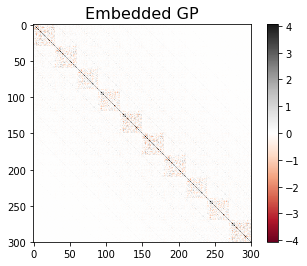

In [57]:
#Embedd a GP and add noise

N = 30
spatial_scale = 1
temporal_scale = 5
K = cca.synth_data.gen_gp_kernel("squared_exp", spatial_scale=spatial_scale, temporal_scale=temporal_scale)

noise_dim = 10
noise_var = 10
noise_cov = gen_noise_cov(N, noise_dim, noise_var)

T = 100
d = 10
T_pi = 5
num_to_concat = 1
X, _, _, _, cross_cov_mats = cca.synth_data.embed_gp(T, N, d, K, noise_cov, T_pi, num_to_concat=num_to_concat)

cov = cca.cov_util.calc_cov_from_cross_cov_mats(cross_cov_mats)
disp_cov(cov, "Embedded GP")
#plt.savefig("figs/embedded_gp_cov.pdf", bbox_inches="tight")
plt.show()

In [58]:
dim_vals, cca_pi_vals, pca_pi_vals, V_set = cca_pca(N, T_pi, cross_cov_mats, num_reps=1)

1 3.9275033105914727 0.0219917957931253
2 7.430050774966515 0.028044896808819445
3 10.221374786885312 0.04014084470126628
4 12.701376237903899 0.11104799091320734
5 14.511729190701347 0.1920810738516456
6 16.227255588758613 0.21275810745949858
7 17.18906793722958 0.3931178344198843
8 18.074226766048884 0.5444252810462543
9 18.552508721368966 0.7431775003114238
10 18.984793352368932 1.1024442091846383
11 18.984793341597545 2.0615095913456782
12 18.984793353876068 2.637198099245789
13 18.98479333493739 3.245624212380065
14 18.984793348298968 4.886201813861616
15 18.984793354263577 5.7370039979789
16 18.984793351514522 6.7569080736767075
17 18.984793355272917 7.731412225401895
18 18.984793356970506 8.376371626595287
19 18.98479335877285 9.615475979019486
20 18.984793357825694 11.496898486581426
21 18.984793358603003 12.332705902531849
22 18.98479335802342 13.326610632906469
23 18.984793359576035 14.395552114701744
24 18.984793353277638 15.577518053371119
25 18.98479335626188 16.7726654223

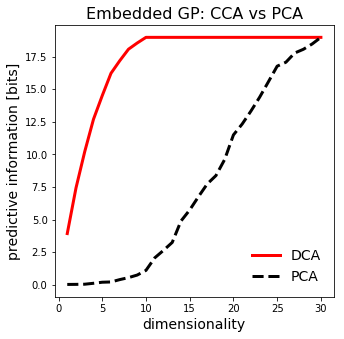

In [59]:
plot_cca_pca(dim_vals, cca_pi_vals, pca_pi_vals, title="Embedded GP: CCA vs PCA")
#plt.savefig("figs/embedded_gp_cca.pdf", bbox_inches="tight")
plt.show()

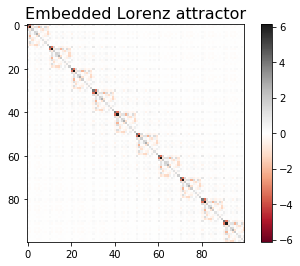

In [354]:
#Embedded Lorenz attractor

N = 10
T = 10000
integration_dt = 0.005
data_dt = 0.05

noise_dim = 3
noise_var = 10
noise_cov = gen_noise_cov(N, noise_dim, noise_var)

X = cca.synth_data.embed_lorenz_system(T, integration_dt, data_dt, N, noise_cov)

T_pi = 5
cross_cov_mats = cca.cov_util.calc_cross_cov_mats_from_data(X, 2*T_pi)

cov = cca.cov_util.calc_cov_from_cross_cov_mats(cross_cov_mats)
disp_cov(cov, "Embedded Lorenz attractor")
#plt.savefig("figs/embedded_lorenz_cov.pdf", bbox_inches="tight")
plt.show()

In [389]:
dim_vals, cca_pi_vals, pca_pi_vals, V_set = cca_pca(N, T_pi, cross_cov_mats, num_reps=1, min_dim=1, max_dim=6)

1 3.7539764570872585 0.006945650329421846
2 5.644795289440149 0.014443266196376994
3 5.90649577880661 0.0340288643115341
4 5.908362467061336 1.0940415497499663
5 5.910423123952333 2.9004398255514903
6 5.91262602492933 3.3041960748148402


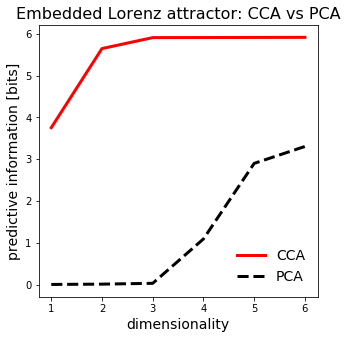

In [390]:
plot_cca_pca(dim_vals, cca_pi_vals.mean(axis=1), pca_pi_vals,  "Embedded Lorenz attractor: CCA vs PCA")
#plt.savefig("figs/embedded_lorenz_cca.pdf", bbox_inches="tight")
plt.show()

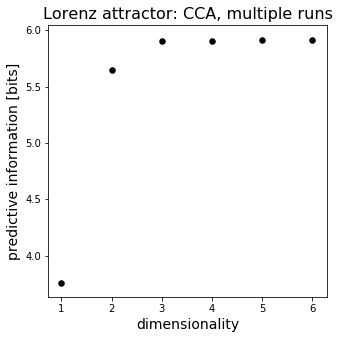

In [391]:
plot_cca_multiple_runs(dim_vals, V_set, cca_pi_vals, title="Lorenz attractor: CCA, multiple runs")
plt.show()

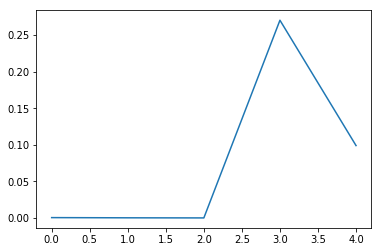

In [392]:
errs = check_nested_subspaces(V_set)
plt.plot(errs)

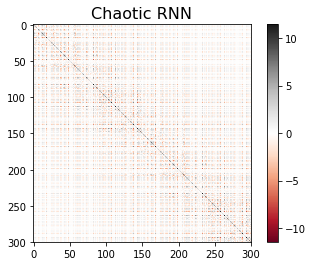

In [324]:
#Load RNN data

f = h5py.File("rnn_data.hdf5", "r")
X_full = f["data"]
T_full, N = X_full.shape
dt_full = f.attrs["dt"]

#Load a few hours of data (24 hours available)
num_hours = 10

#and grab a reduced set of neurons
N = 30

T = int(np.round( num_hours*60**2 / dt_full ))
dt = 0.100
skip = int(np.round( dt / dt_full ))
X = X_full[0:T:skip, :N]

T_pi = 5
cross_cov_mats = cca.cov_util.calc_cross_cov_mats_from_data(X, 2*T_pi)
cov = cca.cov_util.calc_cov_from_cross_cov_mats(cross_cov_mats)

disp_cov(cov, "Chaotic RNN")
#plt.savefig("figs/rnn_cov.pdf", bbox_inches="tight")
plt.show()

In [351]:
dim_vals, cca_pi_vals, pca_pi_vals, V_set = cca_pca(N, T_pi, cross_cov_mats, min_dim=1, max_dim=5, num_reps=1)

1 2.161156887281543 1.5985613588938534
2 2.9315140190936853 2.327914526399957
3 3.9292253411451044 2.660552774895605
4 4.535373663753842 3.4356774289171472
5 5.145857621809781 4.0139304583218935


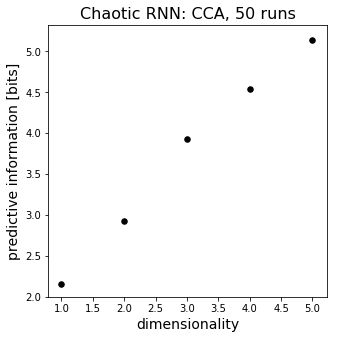

In [352]:
plot_cca_multiple_runs(dim_vals, V_set, cca_pi_vals, title="Chaotic RNN: CCA, 50 runs")
plt.show()

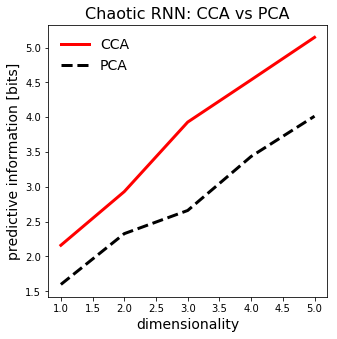

In [353]:
plot_cca_pca(dim_vals, cca_pi_vals.mean(axis=1), pca_pi_vals, title="Chaotic RNN: CCA vs PCA")
#plt.savefig("figs/rnn_cca.pdf", bbox_inches="tight")
plt.show()

In [343]:
dim_vals

array([1, 2, 3, 4, 5])

In [100]:
"""
So we think that the chaotic RNN has a lot of degeneracy which is making
1) the subsets not be nested and
2) some subspaces not agree on different runs. 

For each d:
    Run n times, get n subspaces
    Count how many distinct subspaces you get and how many of each
    
    
d dimensionalities, n subspaces, n-choose-2 comparisons --> PI and sum of pr. angles

"""

'\nSo we think that the chaotic RNN has a lot of degeneracy which is making\n1) the subsets not be nested and\n2) some subspaces not agree on different runs. \n\nFor each d:\n    Run n times, get n subspaces\n    Count how many distinct subspaces you get and how many of each\n    \n    \nd dimensionalities, n subspaces, n-choose-2 comparisons --> PI and sum of pr. angles\n\n'